Sources: Prado's Advances in Financial Machine learning

In [1]:
import math
import numpy as np
import pandas as pd
import quandl
import statsmodels.tsa.stattools as st

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

#plotting libraries
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import seaborn as sns

#Initialize figure size (in inches)
plt.rcParams['figure.figsize'] = [10,5]

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

import os

In [2]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [3]:
def adf(series):
    adf_result = st.adfuller(series, store = True)
    print("ADF Test Results: ")
    print("Test Statistic: %.4f" % adf_result[0])
    print("p-value: %.10f" % adf_result[1])
    print("Critical Values: ")
    for key, value in adf_result[2].items():
        print('\t%s: %0.3f' % (key, value))

In [4]:
def kpss(series):
    kpss_result = st.kpss(series, store=True)
    print("KPSS Test Results: ")
    print("Test Statistic: %.4f" % kpss_result[0])
    print("p-value: %.10f" % kpss_result[1])
    print("Critical Values: ")
    for key, value in kpss_result[2].items():
        print('\t%s: %0.3f' % (key, value))

=========================================================================================================================

# Load TSLA from quandl 

* Quandl unifies financial and economic datasets from hundreds of publishers on a single user-friendly platform.

* Most datasets on Quandl are available directly in Python, using the Quandl Python module.

* The Quandl Python package is free to use and grants access to all free datasets.

In [5]:
#set API key (saved locally on machine)
quandl.ApiConfig.api_key = os.environ.get('quandl_api_key')

* If you are not familiar with quandl database and its functions, try using dir and help functions.

In [7]:
# documentation of quandl.get
help(quandl.get)

Help on function get in module quandl.get:

get(dataset, **kwargs)
    Return dataframe of requested dataset from Quandl.
    :param dataset: str or list, depending on single dataset usage or multiset usage
            Dataset codes are available on the Quandl website
    :param str api_key: Downloads are limited to 50 unless api_key is specified
    :param str start_date, end_date: Optional datefilers, otherwise entire
           dataset is returned
    :param str collapse: Options are daily, weekly, monthly, quarterly, annual
    :param str transform: options are diff, rdiff, cumul, and normalize
    :param int rows: Number of rows which will be returned
    :param str order: options are asc, desc. Default: `asc`
    :param str returns: specify what format you wish your dataset returned as,
        either `numpy` for a numpy ndarray or `pandas`. Default: `pandas`
    :returns: :class:`pandas.DataFrame` or :class:`numpy.ndarray`
    Note that Pandas expects timeseries data to be sorte

* Let us extract the stock Tesla (TSLA) from quandl.

In [8]:
tsla = quandl.get('WIKI/TSLA')
tsla.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-06-29,19.0,25.0,17.5,23.9,18766300.0,0.0,1.0,19.0,25.0,17.5,23.9,18766300.0
2010-06-30,25.8,30.4,23.3,23.8,17187100.0,0.0,1.0,25.8,30.4,23.3,23.8,17187100.0
2010-07-01,25.0,25.9,20.3,22.0,8218800.0,0.0,1.0,25.0,25.9,20.3,22.0,8218800.0
2010-07-02,23.0,23.1,18.7,19.2,5139800.0,0.0,1.0,23.0,23.1,18.7,19.2,5139800.0
2010-07-06,20.0,20.0,15.8,16.1,6866900.0,0.0,1.0,20.0,20.0,15.8,16.1,6866900.0


In [9]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1949 entries, 2010-06-29 to 2018-03-27
Data columns (total 12 columns):
Open           1949 non-null float64
High           1949 non-null float64
Low            1949 non-null float64
Close          1949 non-null float64
Volume         1949 non-null float64
Ex-Dividend    1949 non-null float64
Split Ratio    1949 non-null float64
Adj. Open      1949 non-null float64
Adj. High      1949 non-null float64
Adj. Low       1949 non-null float64
Adj. Close     1949 non-null float64
Adj. Volume    1949 non-null float64
dtypes: float64(12)
memory usage: 197.9 KB


* No missing value

In [10]:
tsla.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,1949.0,1949.0,1949.0,1949.0,1949.0,1949.0,1949.0,1949.0,1949.0,1949.0,1949.0,1949.0
mean,158.7,161.3,155.9,158.6,4548989.3,0.0,1.0,158.7,161.3,155.9,158.6,4548989.3
std,111.1,112.6,109.4,111.0,4185588.3,0.0,0.0,111.1,112.6,109.4,111.0,4185588.3
min,16.1,16.6,15.0,15.8,118500.0,0.0,1.0,16.1,16.6,15.0,15.8,118500.0
25%,31.6,32.2,30.9,31.6,1350400.0,0.0,1.0,31.6,32.2,30.9,31.6,1350400.0
50%,192.1,195.1,189.0,192.7,3715161.0,0.0,1.0,192.1,195.1,189.0,192.7,3715161.0
75%,240.5,244.1,235.7,240.2,6076998.0,0.0,1.0,240.5,244.1,235.7,240.2,6076998.0
max,386.7,389.6,379.3,385.0,37163900.0,0.0,1.0,386.7,389.6,379.3,385.0,37163900.0


* Note that all descriptive statistics of Open, High, Low, Close and Volume are the same as Adj. Open, Adj. High, Adj. Low, Adj. Close and Adj. Volume respectively.

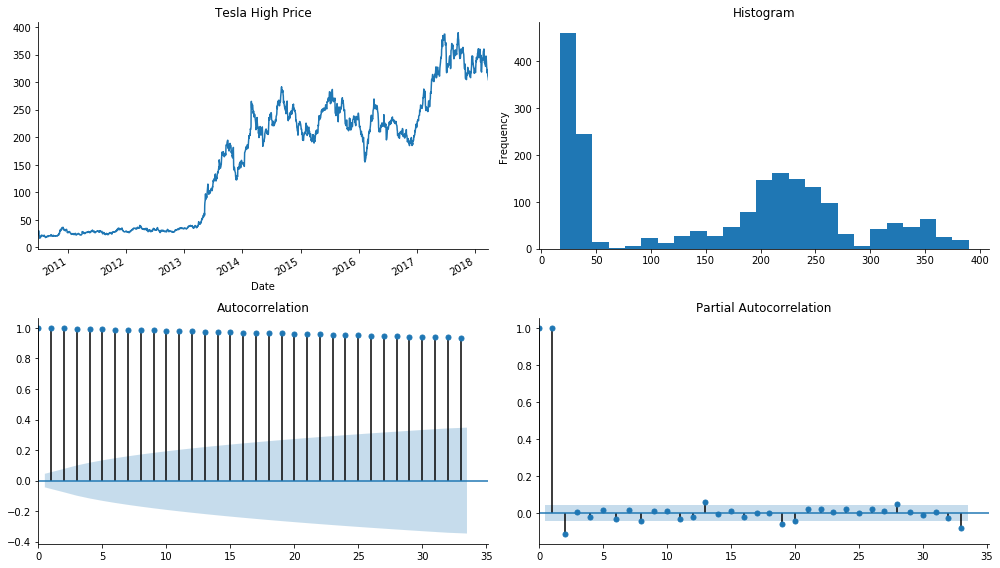

In [11]:
tsplot(tsla['High'], title = 'Tesla High Price');

* ACF and PACF of Tesla resemble AR(2) model. This might suggest that fitting ARMA$(2,0)$ is a good guess.

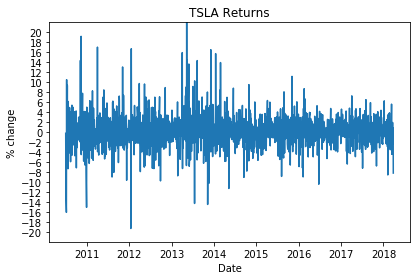

In [13]:
#extract close price values to get numpy array of values
price_list = tsla['Adj. Close'].values

#shift price list by one down and replace first entry with na value
shifted_prices = np.roll(price_list, shift=1, axis=0)
shifted_prices[:1] = np.nan

#calculate returns numpy array
tsla_returns = ((price_list - shifted_prices)/shifted_prices)*100

#plot graph of returns below
plt.ylabel("% change")
plt.yticks(np.arange(-20,21,2))
plt.ylim(-22,22)

plt.xlabel("Date")
plt.title("TSLA Returns")
plt.tight_layout()
plt.plot(tsla.index, tsla_returns);

=========================================================================================================================

# Motivation of Fractional Differencing

* Returns are stationary but memoryless while price series have memory but non-stationary.

* $\textbf{Integer differencing wipe out all memories.}$

* There is a trade-off between stationarity and memory.

Recall that $L$ is the lag operator.
For a real number $d,$ we have 

$$\begin{align*}
(1-L)^d & = \sum_{k=0}^\infty \binom{d}{k} (-L)^k \\
& = 1 - dL + \frac{d(d-1)}{2!} L^2 - \frac{d(d-1)(d-2)}{3!} L^3 + \dots
\end{align*}$$

The arithmetic series consists of 

$$\tilde{X}_t = \sum_{k=0}^\infty \omega_k X_{t-k}$$

with 

$$\omega = \left\{1 ,-d, \frac{d(d-1)}{2!}, -\frac{d(d-1)(d-2)}{3!}, \dots,(-1)^k \prod_{i=0}^{k-1} \frac{(d-i)}{k!},\dots \right\}$$

and 

$$X = {X_t, X_{t-1}, X_{t-2},..., X_{t-k},...}$$

If $d$ is an integer, then 

$$\prod_{i=0}^{k-1} \frac{(d-i)}{k!} = 0 \quad \text{for all } k>d.$$

=========================================================================================================================

# Fractional Differencing Part 1: Finding weights & Formula

* For $k\geq 1,$ if $w_0 = 1,$ the weights can be generated iteratively as:

$$w_k = - w_{k-1} \frac{d-k+1}{k}.$$

* The following findWeights_FFD and fracDiff functions are similar to functions Snippet 5.1 (page $79$) and Snippet 5.2 (page $82$) in Prado's book.

In [14]:
"""Computes the weights for our fractionally differenced features up to a given threshold
   requirement for fixed-window fractional differencing. 
    Args:
        d: A float representing the differencing factor
        length: An int length of series to be differenced
        threshold: A float representing the minimum threshold to include weights for
    Returns:
        A numpy array containing the weights to be applied to our time series
"""
def findWeights_FFD(d, length, threshold):
    #set first weight to be 1 and k to be 1
    w, k = [1.], 1
    w_curr = 1
    
    #while we still have more weights to process, do the following:
    while(k < length):
        
        w_curr = (-w[-1]*(d-k+1))/k
        
        #if the current weight is below threshold, exit loop
        if(abs(w_curr) <= threshold):
            
            break
            
        #append coefficient to list if it passes above threshold condition
        w.append(w_curr)
        
        #increment k
        k += 1
        
    #make sure to convert it into a numpy array and reshape from a single row to a single
    #column so they can be applied to time-series values easier
    w = np.array(w[::-1]).reshape(-1,1)
    
    return w

In [15]:
"""Computes fractionally differenced series 
    Args:
        d: A float representing the differencing factor (any positive fractional)
        series: A pandas dataframe with one or more columns of time-series values to be differenced
        threshold: Threshold value past which we ignore weights 
            (cutoff weight for window)
    Returns: 
        diff_series: A numpy array of differenced series by d. 
"""
def fracDiff(series, d, threshold = 1e-5):
    #compute weights using function above
    weights = findWeights_FFD(d, len(series), threshold)
    width = len(weights) - 1
    
    df = {}
    #for each series to be differenced, apply weights to appropriate prices and save 
    for name in series.columns:
        
        #forward fill through unavailable prices and create a temporary series to hold values
        curr_series = series[[name]].fillna(method='ffill').dropna()
        df_temp = pd.Series()
        
        #loop through all values that fall into range to be fractionally differenced
        for iloc1 in range(width, curr_series.shape[0]):
            
            #set values for first and last time-series point to be used in current pass of fractional
                #difference
            loc0 = curr_series.index[iloc1-width]
            loc1 = curr_series.index[iloc1]
            
            #make sure current value is valid
            if not np.isfinite(curr_series.loc[loc1,name]):
                continue
            
            #dot product of weights with values from first and last indices
            df_temp[loc1]= np.dot(weights.T, curr_series.loc[loc0:loc1])[0,0]
            
        df[name] = df_temp.copy(deep=True)
    df = pd.concat(df, axis=1)
            
    return df

=========================================================================================================================

# Fractional Differencing Part 2: Test-Run/Sanity Check

In [16]:
test_series = tsla[['Adj. Close']]
df_result = fracDiff(test_series, 0.5, 1e-5)

df_result

,Adj. Close
2014-03-05,22.5
2014-03-06,22.3
2014-03-07,14.7
2014-03-10,9.9
2014-03-11,9.4
...,...
2018-03-21,5.8
2018-03-22,-3.3
2018-03-23,-7.1
2018-03-26,0.4


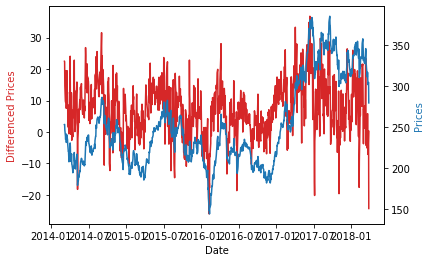

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Differenced Prices', color=color)
ax1.plot(df_result.index, df_result['Adj. Close'], color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Prices', color = color)
ax2.plot(df_result.index, tsla['Adj. Close'].values[-(df_result.shape[0]):], color=color)

plt.show()

=========================================================================================================================

# The ADF and KPSS Tests for stationarity

1. $\textbf{ADF Test}$: This test is used to detect the presence of a unit-root.

2. $\textbf{KPSS Test}$: This test is used to detect the presence of trend-stationarity around a deterministic trend.


* These two tests are meant to complement each other. By testing both the unit-root and trend-stationarity, it gives us a better idea of where we can categorize the stochastic behaviour of our data

In [18]:
#Running the adf test and displaying results
adf(df_result['Adj. Close'])

ADF Test Results: 
Test Statistic: -6.8293
p-value: 0.0000000019
Critical Values: 
	1%: -3.437
	5%: -2.864
	10%: -2.568


This is definitely a good thing since such a low p-value is basically telling us there is no unit root (and hence no non-stationary trend in our data).

In [19]:
#Running the kpss test and displaying results
kpss(df_result['Adj. Close'])

KPSS Test Results: 
Test Statistic: 0.2992
p-value: 0.1000000000
Critical Values: 
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Although at least 10% doesn't sound like a whole lot, it definitely is in statistics. This test also further shows that our series is in-fact very likely to be trend-stationary.

# Varying Starting Conditions: How do test results fare?

Are you curious on how our test results change as our differencing parameter changes? So, below, let us look at how changing our threshold value (for fractional differencing coefficients) and differencing factors change the results of the adf test results.

I also decide to take a look at how these parameters change the number of data points we are able to difference (or the length of the differenced series).

In [ ]:
# Please wait for at least 5 minutes for the cell to run completely

pd.options.display.float_format = '{:.5f}'.format

#the 130 combinations to test, varying values of our thresholds and differencing factors
thresh_values = [1e-3, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 9e-5, 7e-5, 5e-5, 3e-5]
diff_values = [0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2]

#dataframe to hold results
pval_hyperparam_df = pd.DataFrame(0.1, columns = thresh_values, index=diff_values)

#dataframe to hold lengths 
lengths_df = pd.DataFrame(1, columns = thresh_values, index = diff_values)

#to keep track of column and row indices when placing results in dataframe
col = 0
row = 0

#cycle through each combination of threshold values and diff values
    # and generate adf test-statistics for each combination
    
for i in thresh_values:
    for j in diff_values:
        
        #fractionally difference series and store series lengths
        test_diff_series = fracDiff(test_series, j, i)
        lengths_df.iat[row,col] = test_diff_series.shape[0]
        
        #run and collect adf fuller test
        test_adf_result = st.adfuller(test_diff_series['Adj. Close'], regression = 'ctt', store = True)
        
        pval_hyperparam_df.iat[row, col] = test_adf_result[0]
        
        row += 1
    row = 0
    col += 1
    
#display our results
(pval_hyperparam_df)
display(lengths_df)

In [ ]:
#Heatmap plot just so we get a better idea of how these changes are happening
heatmap = sns.heatmap(pval_hyperparam_df, vmin=0, vmax=-12, annot=True)

We see that higher amounts of differencing do typically lead to much more negative test-statistics (which translate to very low p-values). All in all, this basically tells us that as we increase our differencing factor our series becomes more stationary. This would make sense since we typically take first differences (d=1) to get returns which are considered stationary.

What this chart highlights is the fact that we don't actually have to overly difference a series to get trend-stationarity in the underlying series.

Also notice that lowering our threshold, holding the differencing-factor constant, lowers the number of observations we can difference (and this is much more pronounced for lower differencing factors since the values converge much quicker). The same can be said for holding our threshold constant and decreasing our differencing factor.

# Pitfalls, Limitations, Conclusions

So, why do we need to be careful about what we've been studying here? Well, for the ADF test in particular, testing for a unit-root and testing for trend-stationarity aren't exactly the same thing. The weird thing is, it is possible for a time series to be non-stationary but have no unit root.

Trend-stationary tests (like the KPSS test) are really looking for time-series convergence around a certain mean, and this mean can grow or shrink over time. Unit root processes however, assume that shocks to our series have a permanent impact.

Also, in the presence of time-varying variance (which is the case in some of the computed examples above), our results becomes less robust (although this can be easily fixed by conducting other unit root tests such as the Phillips-Peron test that is more robust to heteroskedasticity).

So, what exactly has this series of posts shown? Virtually all finance papers apply integer differencing (a factor of 1) and is usually overkill for most financial time-series. This over-differencing causes most if not all memory to be lost, leaving us very little with regard to information in using prices in statistical models.

I'll conclude with a thought that radically shifted my perspective on quantitative trading:

It's important to think about quantitative trading from a statistical framework. The price path you see in a chart is simply a realized price path, generated from an underlying distribution (that we, unfortunately, don't know much about). Going forward, under repeated sampling, we have to assume that other price paths are also very likely.

Thinking about equity curves and time-series paths in this manner definitely make things more confusing but solidify why statistical ideas, although complex on the surface, are so useful and powerful in giving quants an edge.